In [1]:
import sys
sys.path.append("..")
import ProbabilisticParcellation.util as ut
import ProbabilisticParcellation.hierarchical_clustering as cl
import ProbabilisticParcellation.similarity_colormap as cm
import ProbabilisticParcellation.functional_profiles as fp
from Functional_Fusion.dataset import *
import matplotlib.pyplot as plt
import string
import PcmPy as pcm
from copy import deepcopy
import torch as pt



base_dir = '/Volumes/diedrichsen_data$/data/FunctionalFusion'
if not Path(base_dir).exists():
    base_dir = '/srv/diedrichsen/data/FunctionalFusion'
if not Path(base_dir).exists():
    base_dir = '/Users/callithrix/Documents/Projects/Functional_Fusion/'
if not Path(base_dir).exists():
    raise (NameError('Could not find base_dir'))
    

## Load profile data and model

In [2]:
atlas = 'MNISymC2'

# load model
mname = f'/Models_03/NettekovenSym32_space-{atlas}'
fileparts = mname.split('/')
split_mn = fileparts[-1].split('_')
info, model = ut.load_batch_best(mname)


# load labels and cmap
lut_dir = '/Volumes/diedrichsen_data$/data/Cerebellum/ProbabilisticParcellationModel/Atlases/'
_, cmap, labels = nt.read_lut(lut_dir +
                              f'{fileparts[-1]}.lut')
labels=labels[1:]

# load profile
profile = pd.read_csv(
    f'{ut.model_dir}/Atlases/{fileparts[-1]}_profile.tsv', sep="\t"
)


FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/diedrichsen_data$/data/Cerebellum/ProbabilisticParcellationModel/Atlases/NettekovenSym32_space-MNISymC2_profile.tsv'

In [3]:
profile.head()

Unnamed: 0 dataset session   condition       M1L       M2L      M3aL  \
0           0    MDTB  ses-s1        NoGo  0.007308 -0.155251 -0.054131   
1           1    MDTB  ses-s1          Go  0.057607  0.029169  0.235781   
2           2    MDTB  ses-s1         ToM  0.280441 -0.085992  0.026751   
3           3    MDTB  ses-s1    VideoAct -0.052990  0.581823 -0.216778   
4           4    MDTB  ses-s1  VideoKnots -0.008363  0.280476 -0.096940   

       M3bL      M4aL      M4bL  ...      S2aR      S2bR      S2cR      S2dR  \
0 -0.009731 -0.327032  0.035044  ...  0.065338  0.013747 -0.059765 -0.083025   
1  0.103795  0.060290  0.190120  ... -0.025872 -0.003402 -0.074537 -0.105386   
2 -0.049840 -0.008657 -0.141051  ...  0.627982  0.331534  0.373722  0.192555   
3 -0.235582  0.024034 -0.009431  ... -0.070370 -0.165575 -0.092672  0.063738   
4  0.026103  0.047133  0.071750  ...  0.136239  0.063830  0.158205  0.348435   

        S3R      S4aR      S4bR      S4cR  dataset_colour  dataset_colour_name  
0  0.064362 -0.191257 -0.018708 -0.038257         #1f77b4              #1f77b4  
1 -0.236135 -0.067227 -0.044821 -0.214711         #1f77b4              #1f77b4  
2 -0.001632  0.425068  0.195358  0.458623         #1f77b4              #1f77b4  
3 -0.097279  0.068210 -0.055714  0.018491         #1f77b4              #1f77b4  
4  0.323061  0.264158  0.129202  0.255174         #1f77b4              #1f77b4  

[5 rows x 74 columns]

In [ ]:
def print_highest(profile, df, labels, region=None, dataset=None, n=5):
    d = np.arange(len(df))
    if dataset is not None:  # Choose dataset
        d = np.nonzero((df.dataset == dataset).to_numpy())[0]
    prof = profile[d, :]
    data = df.iloc[d]

    for i, r in enumerate(labels):
        if (region is None) | (r == region):
            print(f'\nregion {r}')

            # Sort conditions by score
            scores = prof[:, i]
            zipped = zip(scores, data.condition, data.dataset)
            zipped = sorted(zipped, key=lambda x: x[0], reverse=True)
            scores, conds, datasets = zip(*zipped[:n])

            [print(f'{dataset} {cond}: {score}') for score, cond, dataset in zip(scores, conds, datasets)]


([<matplotlib.axis.YTick at 0x7facb86325e0>,
 [Text(0, 0, 'NoGo'),
  Text(0, 5, 'UnpleasantScenes'),
  Text(0, 10, 'SadFaces'),
  Text(0, 15, 'FingerSeq'),
  Text(0, 20, 'SpatialNavigation'),
  Text(0, 25, 'VisualSearchSmall'),
  Text(0, 30, 'Prediction'),
  Text(0, 35, 'SpatialNavigation'),
  Text(0, 40, 'RomanceMovie'),
  Text(0, 45, 'MentalRotMed'),
  Text(0, 50, 'BodyMotionScram'),
  Text(0, 55, 'VisualSearchMed'),
  Text(0, 60, 'rest'),
  Text(0, 65, 'theory-of-mind'),
  Text(0, 70, 'AnimalPhoto'),
  Text(0, 75, 'Clock'),
  Text(0, 80, 'DailyPhoto'),
  Text(0, 85, 'DecideShopping'),
  Text(0, 90, 'DomesiticName'),
  Text(0, 95, 'EyeMoveEasy'),
  Text(0, 100, 'ForeignListenQ'),
  Text(0, 105, 'ImagineIf'),
  Text(0, 110, 'MapIcon'),
  Text(0, 115, 'MemoryDigit'),
  Text(0, 120, 'MirrorImage'),
  Text(0, 125, 'PressLR'),
  Text(0, 130, 'PropLogic'),
  Text(0, 135, 'RateDeliciousMov'),
  Text(0, 140, 'RateHappyMov'),
  Text(0, 145, 'RatePoem'),
  Text(0, 150, 'RateSleepy'),
  Text(0,

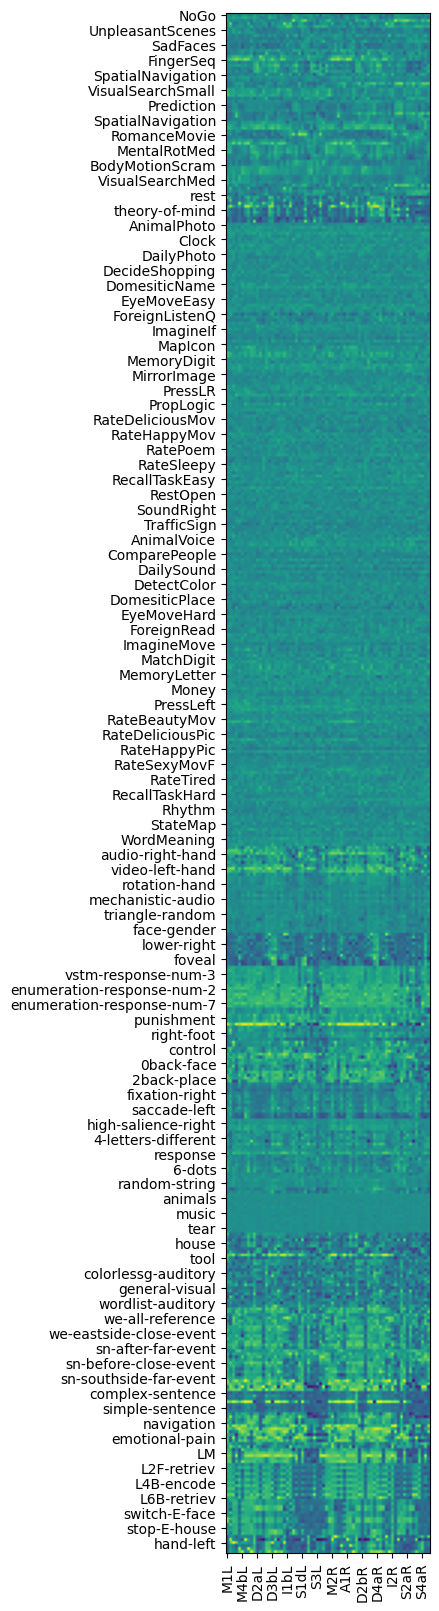

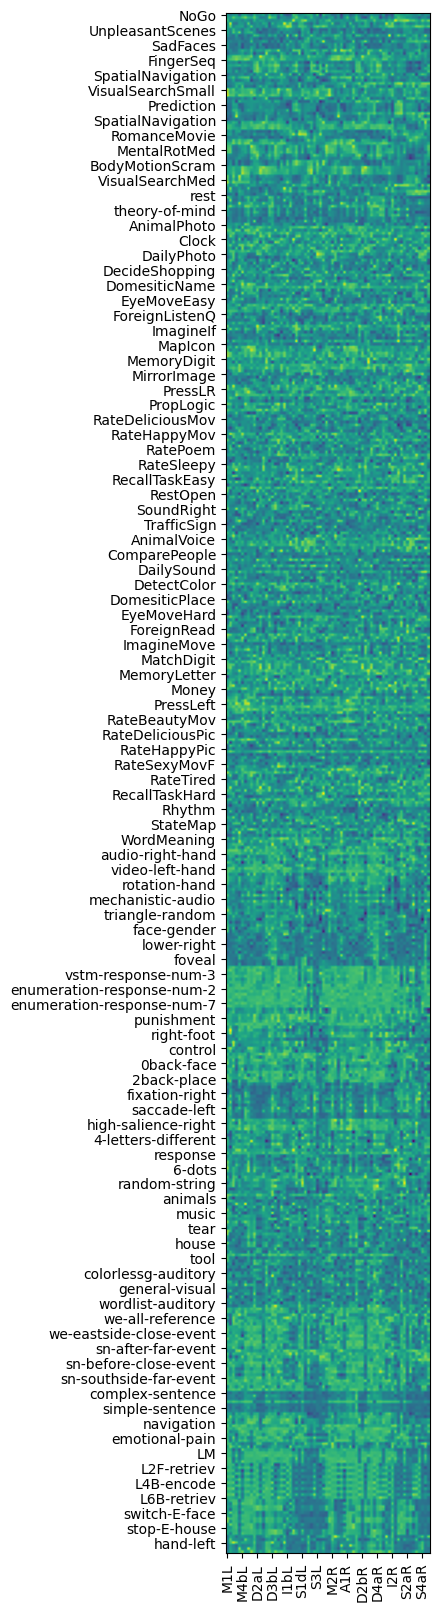

In [ ]:
# Normalize profile
profile_mat = profile[labels].to_numpy()
profile_norm = profile_mat / np.sqrt(np.sum(profile_mat**2, axis=1).reshape(-1, 1))


# Show profile
plt.figure(figsize=(40, 20))
plt.imshow(profile_mat)
plt.xticks(np.arange(len(labels))[::5], labels[::5], rotation=90)
plt.yticks(np.arange(len(profile))[::5], profile.condition[::5])


# Show normalized profile
plt.figure(figsize=(40, 20))
plt.imshow(profile_norm)
plt.xticks(np.arange(len(labels))[::5], labels[::5], rotation=90)
plt.yticks(np.arange(len(profile))[::5], profile.condition[::5])


In [6]:
region = 'M4aL'
dataset='Somatotopic'

print_highest(profile_norm, profile, labels, region=region, dataset=dataset)
print_highest(profile_mat, profile, labels, region=region, dataset=dataset)



region M4aL
Somatotopic foot-left: 0.26190663486485244
Somatotopic glutes: 0.14626584139896026
Somatotopic foot-right: 0.008532908813534914
Somatotopic hand-left: -0.017639909701400343
Somatotopic hand-right: -0.04952763751657172

region M4aL
Somatotopic foot-left: 0.8018838
Somatotopic glutes: 0.5157218
Somatotopic foot-right: 0.025101777
Somatotopic hand-left: -0.052393615
Somatotopic hand-right: -0.13906373


In [7]:
region = 'M4bL'
dataset = 'Somatotopic'

print_highest(profile_norm, profile, labels, region=region, dataset=dataset)
print_highest(profile_mat, profile, labels, region=region, dataset=dataset)



region M4bL
Somatotopic glutes: 0.22222894463352078
Somatotopic hand-left: 0.07128152561543619
Somatotopic hand-right: -0.001312347468297008
Somatotopic foot-left: -0.0479841428775678
Somatotopic foot-right: -0.09714942700373333

region M4bL
Somatotopic glutes: 0.7835617
Somatotopic hand-left: 0.21171859
Somatotopic hand-right: -0.00368481
Somatotopic foot-left: -0.14691383
Somatotopic foot-right: -0.28579038


### Load cognitive feature tags

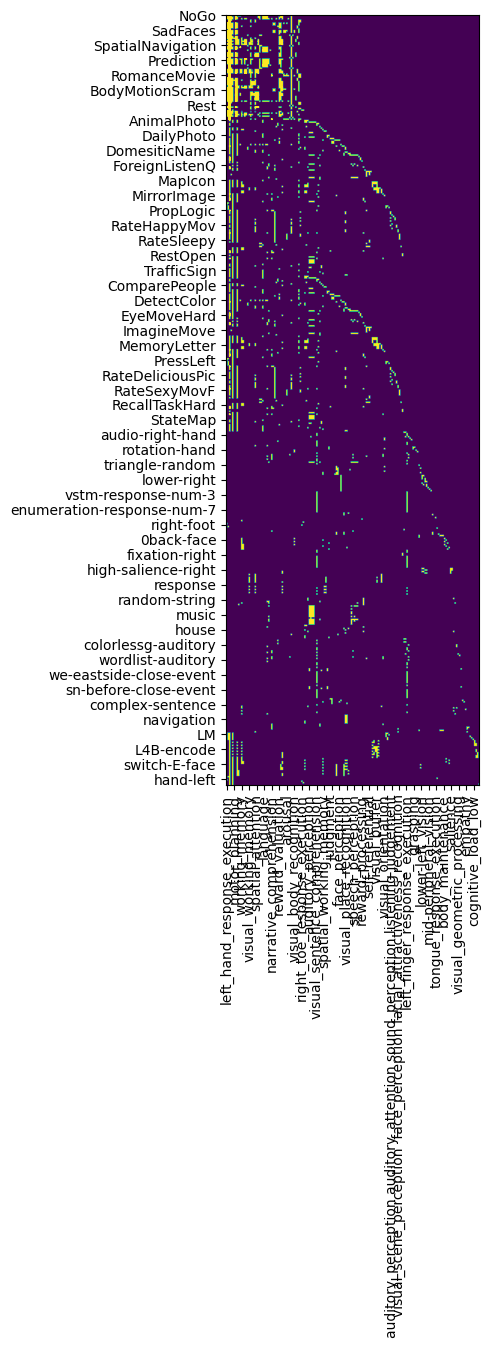

In [8]:
tags = pd.read_csv(
    f'{ut.model_dir}/Atlases/Profiles/tags/tags.csv', sep="\t"
)
# Show tags
tags_mat = tags[tags.columns[3:]].to_numpy()
plt.figure(figsize=(10, 10))
plt.imshow(tags_mat, vmin=0, vmax=1)
plt.xticks(np.arange(len(tags.columns[3:]))[::5], tags.columns[3:][::5], rotation=90)
plt.yticks(np.arange(len(tags))[::10], tags.condition[::10])
# Make figure wider
plt.gcf().set_size_inches(100, 10)

([<matplotlib.axis.XTick at 0x7faca9c34280>,
 [Text(0, 0, 'M1L'),
  Text(5, 0, 'M4bL'),
  Text(10, 0, 'D2aL'),
  Text(15, 0, 'D3bL'),
  Text(20, 0, 'I1bL'),
  Text(25, 0, 'S1dL'),
  Text(30, 0, 'S3L'),
  Text(35, 0, 'M2R'),
  Text(40, 0, 'A1R'),
  Text(45, 0, 'D2bR'),
  Text(50, 0, 'D4aR'),
  Text(55, 0, 'I2R'),
  Text(60, 0, 'S2aR'),
  Text(65, 0, 'S4aR')])

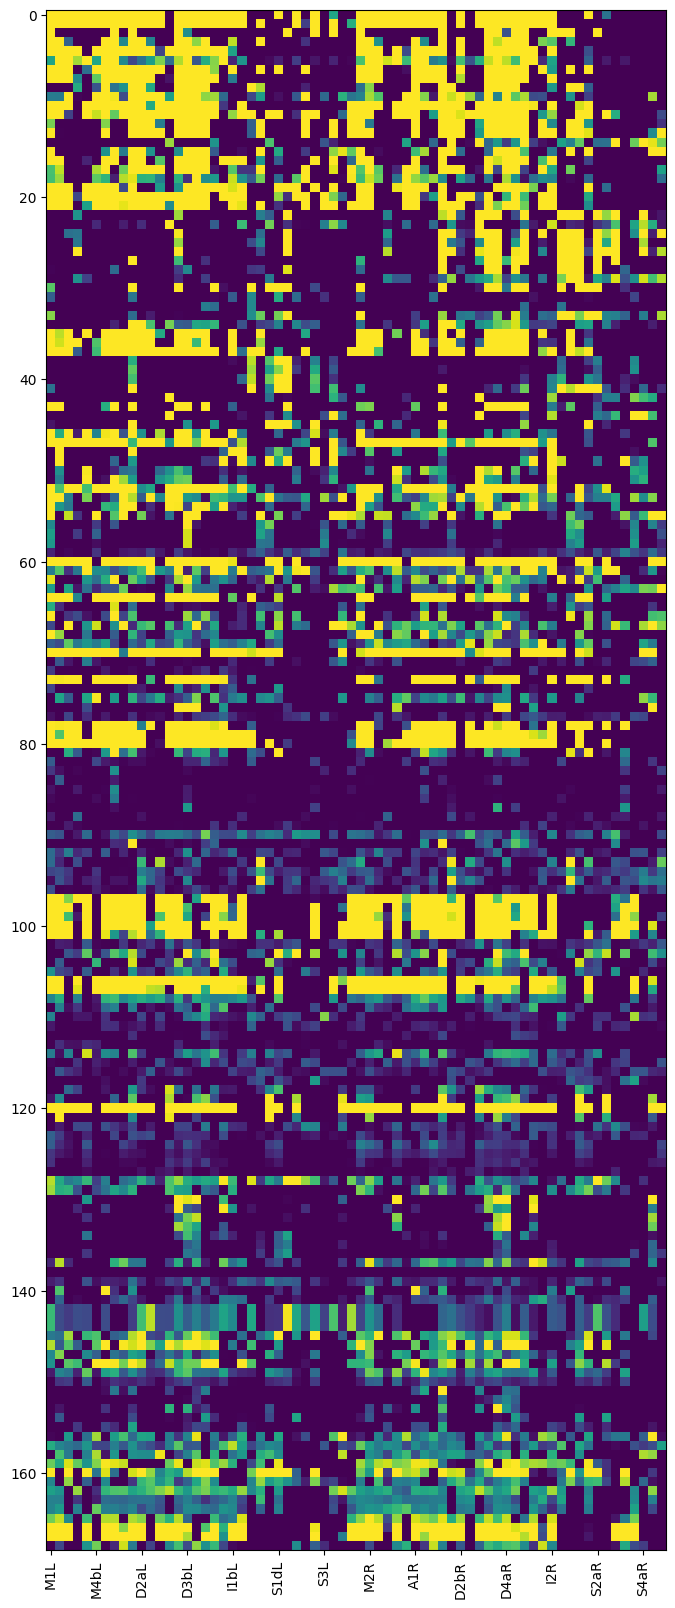

In [9]:
# Multiply profile by tags
features = profile_mat.T @ tags_mat
features = features.T
plt.figure(figsize=(20, 20))
plt.imshow(features, vmin=0, vmax=1)
plt.xticks(np.arange(len(labels))[::5], labels[::5], rotation=90)


([<matplotlib.axis.XTick at 0x7face891d520>,
 [Text(0, 0, 'M1L'),
  Text(5, 0, 'M4bL'),
  Text(10, 0, 'D2aL'),
  Text(15, 0, 'D3bL'),
  Text(20, 0, 'I1bL'),
  Text(25, 0, 'S1dL'),
  Text(30, 0, 'S3L'),
  Text(35, 0, 'M2R'),
  Text(40, 0, 'A1R'),
  Text(45, 0, 'D2bR'),
  Text(50, 0, 'D4aR'),
  Text(55, 0, 'I2R'),
  Text(60, 0, 'S2aR'),
  Text(65, 0, 'S4aR')])

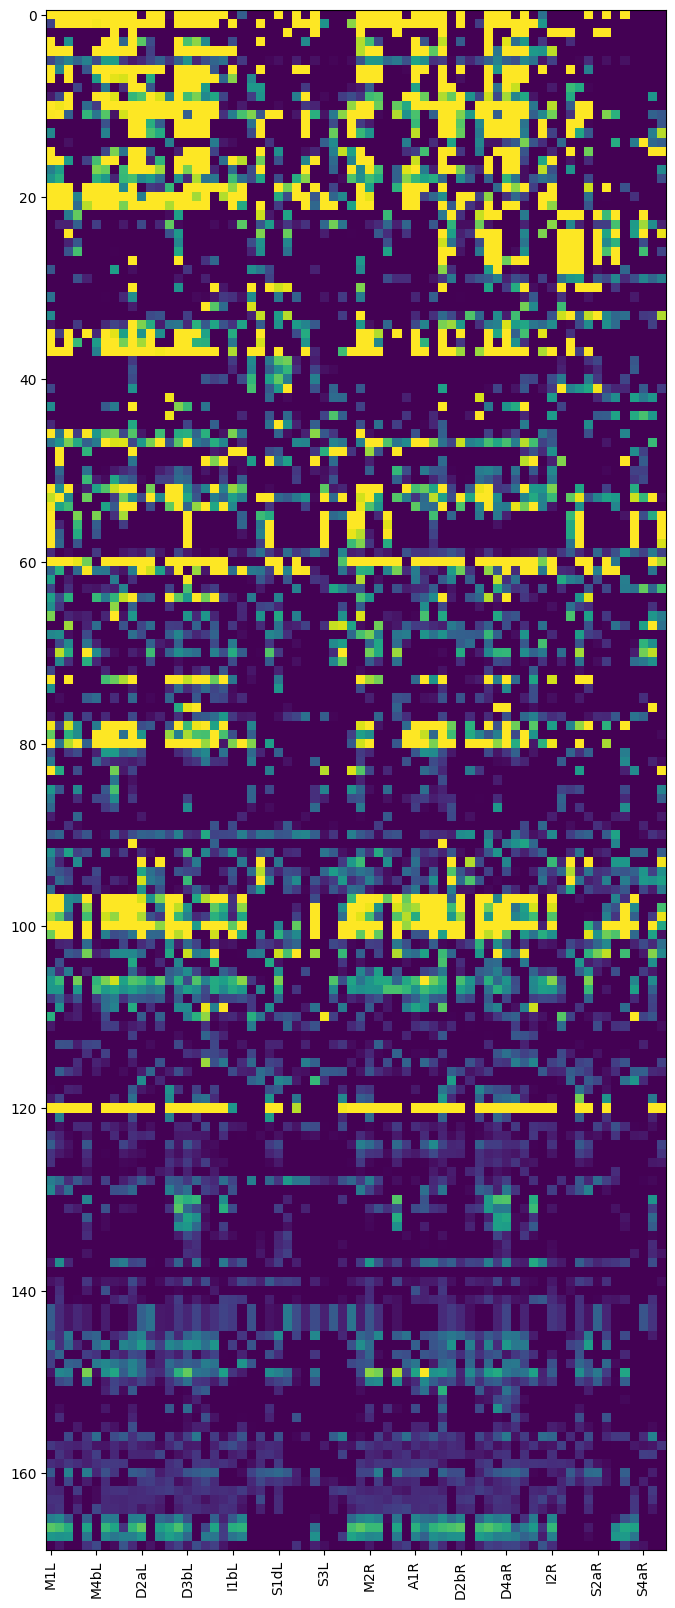

In [10]:
# Multiply normalized profile by tags
features_norm = profile_norm.T @ tags_mat
features_norm = features_norm.T
plt.figure(figsize=(20, 20))
plt.imshow(features_norm, vmin=0, vmax=1)
plt.xticks(np.arange(len(labels))[::5], labels[::5], rotation=90)


In [11]:
def print_tags(profile, df, labels, region=None, n=5):

    for i, r in enumerate(labels):
        if (region is None) | (r == region):
            print(f'\nregion {r}')

            # Sort conditions by score
            scores = profile[:, i]
            zipped = zip(scores, df.columns[3:])
            zipped = sorted(zipped, key=lambda x: x[0], reverse=True)
            scores, conds = zip(*zipped[:n])

            [print(f'{cond}: {score}')
             for score, cond in zip(scores, conds)]


In [12]:
dataset = 'Somatotopic'

for region in ['M1R', 'M2R', 'M3aR', 'M3bR', 'M3bL', 'M4aR']:
    print_highest(profile_norm, profile, labels, region=region, dataset=dataset)
    # print_highest(profile_mat, profile, labels, region=region)
    # print_tags(features, tags, labels, region=region)
    print_tags(features_norm, tags, labels, region=region, n=10)



region M1R
Somatotopic tongue: -0.07349546141331743
Somatotopic glutes: -0.1084920624466138
Somatotopic hand-right: -0.10906969346010026
Somatotopic hand-left: -0.11988169916150544
Somatotopic foot-right: -0.15896319429569924

region M1R
left_hand_response_execution: 12.32650772572504
visual_sentence_comprehension: 5.316109644933814
response_alternative: 4.13326251085434
left_finger_response_execution: 4.122938906980177
visual_attention: 3.7390081267181965
attentional_focusing: 3.15119841205484
spatial_attention: 3.096862356979261
working_memory: 2.7473823550240284
visual_buffer: 2.5228894278864997
task_difficulty: 2.4255855717751467

region M2R
Somatotopic tongue: 0.17777773081449813
Somatotopic hand-right: 0.15823177795183216
Somatotopic hand-left: 0.08689793655477702
Somatotopic glutes: 0.06477722296796924
Somatotopic foot-right: 0.049266336686270305

region M2R
right_hand_response_execution: 13.89551518915514
left_hand_response_execution: 8.89488704100785
visual_sentence_comprehen

In [13]:
dataset = None

for region in ['S1aR', 'S2aR', 'S3R', 'S4aR']:
    print_highest(profile_norm, profile, labels,
                  region=region, dataset=dataset)
    # print_highest(profile_mat, profile, labels, region=region)
    # print_tags(features, tags, labels, region=region)
    print_tags(features_norm, tags, labels, region=region, n=10)



region S1aR
IBC p-startup: 0.41406157159463935
Nishimoto Clock: 0.38250003267616073
MDTB ToM: 0.35022659934482625
MDTB ToM: 0.3401205445241647
Nishimoto RateNoisy: 0.33579798973050956

region S1aR
saccadic_eye_movement: 26.20124605748762
lexical_processing: 2.2067017250302103
visual_word_recognition: 1.9368086129109012
narrative_comprehension: 1.8632737537171626
language: 1.8479215667216313
long_term_memory: 1.62135194603118
language_processing: 1.429320008739902
semantic_knowledge: 1.2062132760078272
social_cognition: 1.0377249497324694
creative_thinking: 0.9252506085261332

region S2aR
Nishimoto AnimalVoice: 0.31699048402775515
Nishimoto Metaphor: 0.3146498888705011
Nishimoto ForeignReadQ: 0.31133722722569646
MDTB ToM: 0.29167873300494024
Nishimoto MemoryNameEasy: 0.28657474439569197

region S2aR
saccadic_eye_movement: 69.25094221243118
semantic_knowledge: 1.606654922147864
lexical_processing: 1.5622365721981248
long_term_memory: 1.4556392139872019
language: 1.3515679946717256
narra

In [14]:

dataset = None

for region in ['I1aL',
               'I1bL',
               'I2L']:
    print_highest(profile_norm, profile, labels,
                  region=region, dataset=dataset)
    # print_highest(profile_mat, profile, labels, region=region)
    # print_tags(features, tags, labels, region=region)
    print_tags(features_norm, tags, labels, region=region, n=10)



region I1aL
MDTB VideoAct: 0.3630583435377129
MDTB VideoAct: 0.36243861951801176
Somatotopic hand-left: 0.2943481994712636
Nishimoto PropLogic: 0.28238191304507976
Nishimoto DetectDifference: 0.280102487576955

region I1aL
left_hand_response_execution: 5.744095035977968
film_viewing: 2.7676849207684215
retrieve: 1.8680818075765537
visual_sentence_comprehension: 1.8602173559580837
response_execution: 1.8264020335788431
visual_attention: 1.4998199895388875
feature_comparison: 1.3145394292239676
visual_buffer: 1.2503505660601282
visual_string_recognition: 1.2381389602962969
easy: 1.1871554471444157

region I1bL
MDTB VideoKnots: 0.31586179221670563
IBC we-all-reference: 0.304431011248325
Nishimoto DetectTargetPic: 0.27382728923533395
IBC intersection: 0.25592766544623985
Nishimoto CalcHard: 0.25437935058848105

region I1bL
response_alternative: 2.1205795802438328
spatial_attention: 1.903013837709
visual_object_recognition: 1.8367827514063109
right_hand_response_execution: 1.66461287591388

## Normalizing dataset weight by dataset-ARI
Each dataset is differently relevant for each parcel. For example, the somatotopic dataset influences the motor parcels, but not the language parcels. Therefore, the parcel profile for each parcel should be weighted by how much the parcel was influenced by each dataset.
The local ARI between the parcellation and the single dataset parcellation should tell us how much each voxel was influenced by each dataset,

In [15]:
with open(f'{ut.model_dir}/Models/Evaluation/nettekoven_68/ARI_between-datasets_group.npy', 'rb') as f:
    aris = np.load(f)


# Make stacked ARIs into list of arrays
aris_list = np.split(aris, 8, axis=1) # Split array into 8 sub-arrays along the second axis
aris_list = [a.squeeze() for a in aris_list] # Remove singleton dimensions



<AxesSubplot: title={'center': 'HCP'}>

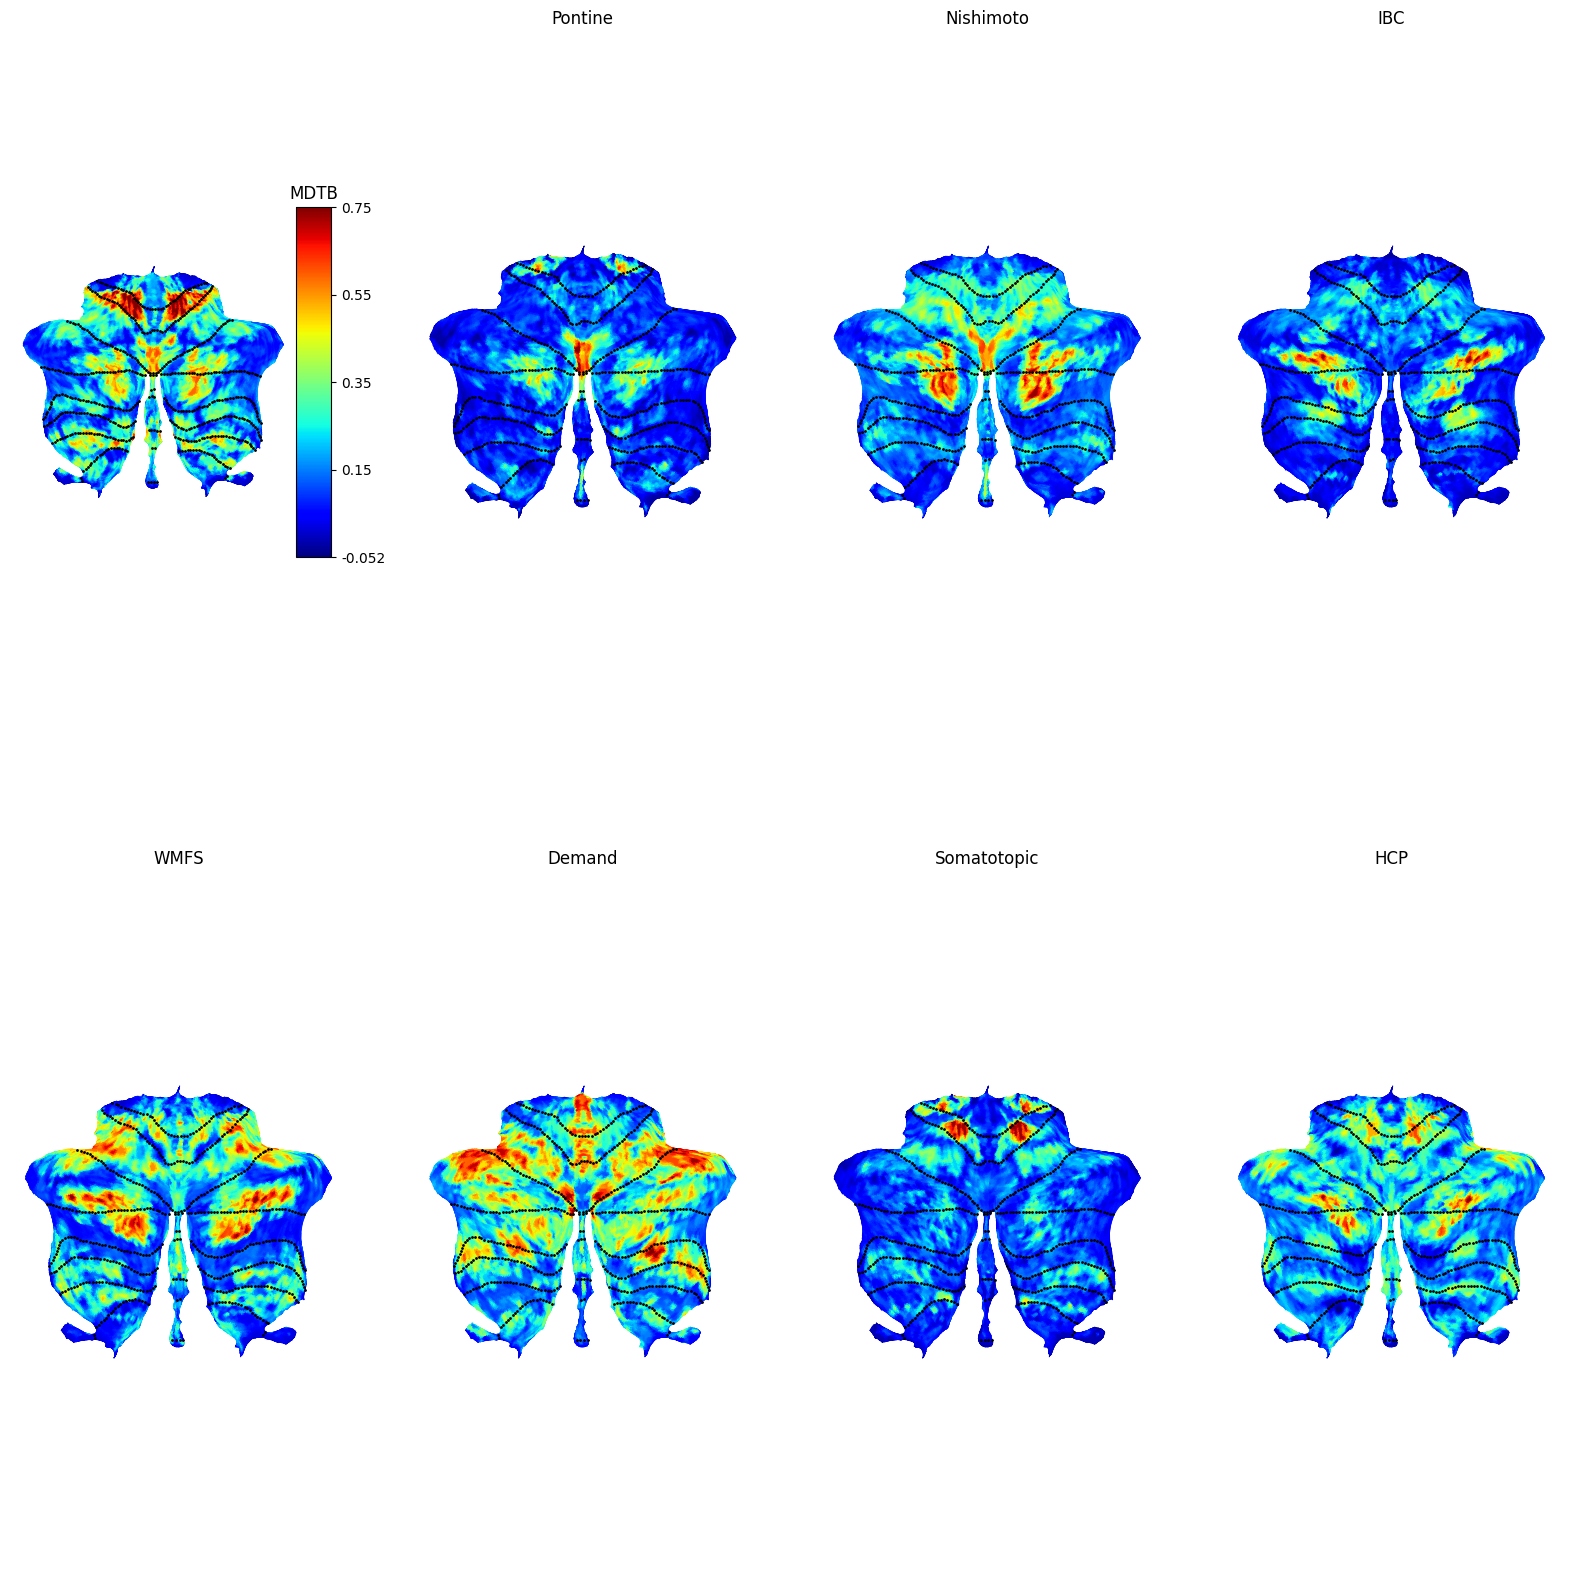

In [16]:
plt.figure(figsize=(20, 20))
T = pd.read_csv(ut.base_dir + '/dataset_description.tsv', sep='\t')
ut.plot_multi_flat(aris_list, 'MNISymC3',
                   grid=(2, 4),
                   dtype='func',
                   colorbar=True,
                   titles=T.name)


In [17]:
# Average ARI within each parcel
infoC3, modelC3 = ut.load_batch_best(
    f'/Models_03/sym_MdPoNiIbWmDeSo_space-MNISymC3_K-68_reordered')

# Get parcel mask
parcel = pt.argmax(modelC3.arrange.marginal_prob(), dim=0).numpy()
parcel_mask = pcm.indicator(parcel)
# Check which parcels have no voxels in the WTA representation
empty_parcel = np.setdiff1d(np.arange(68), np.unique(parcel))
# Add a row of 0 to parcel_mask where parcel_mask is missing a parcel since it has no WTA voxels
parcel_mask = np.insert(parcel_mask, empty_parcel, 0, axis=1)

# Loop through aris in aris_list and average within each parcel mask (replacing nans in weights_flatmap with 0 for visualisation)
mean_weights = [np.matmul(a.reshape(
    1, -1), parcel_mask) / np.sum(parcel_mask, axis=0) for a in aris_list]
# Project mean_weights into the original space
weights_flatmap = np.array([np.matmul(np.nan_to_num(m), parcel_mask.T) for m in mean_weights]).squeeze()



/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_46279/417569760.py:14: RuntimeWarning: invalid value encountered in divide
  mean_weights = [np.matmul(a.reshape(


## Influence of each dataset on the parcellation (within-parcel averaged ARI)

<AxesSubplot: title={'center': 'HCP'}>

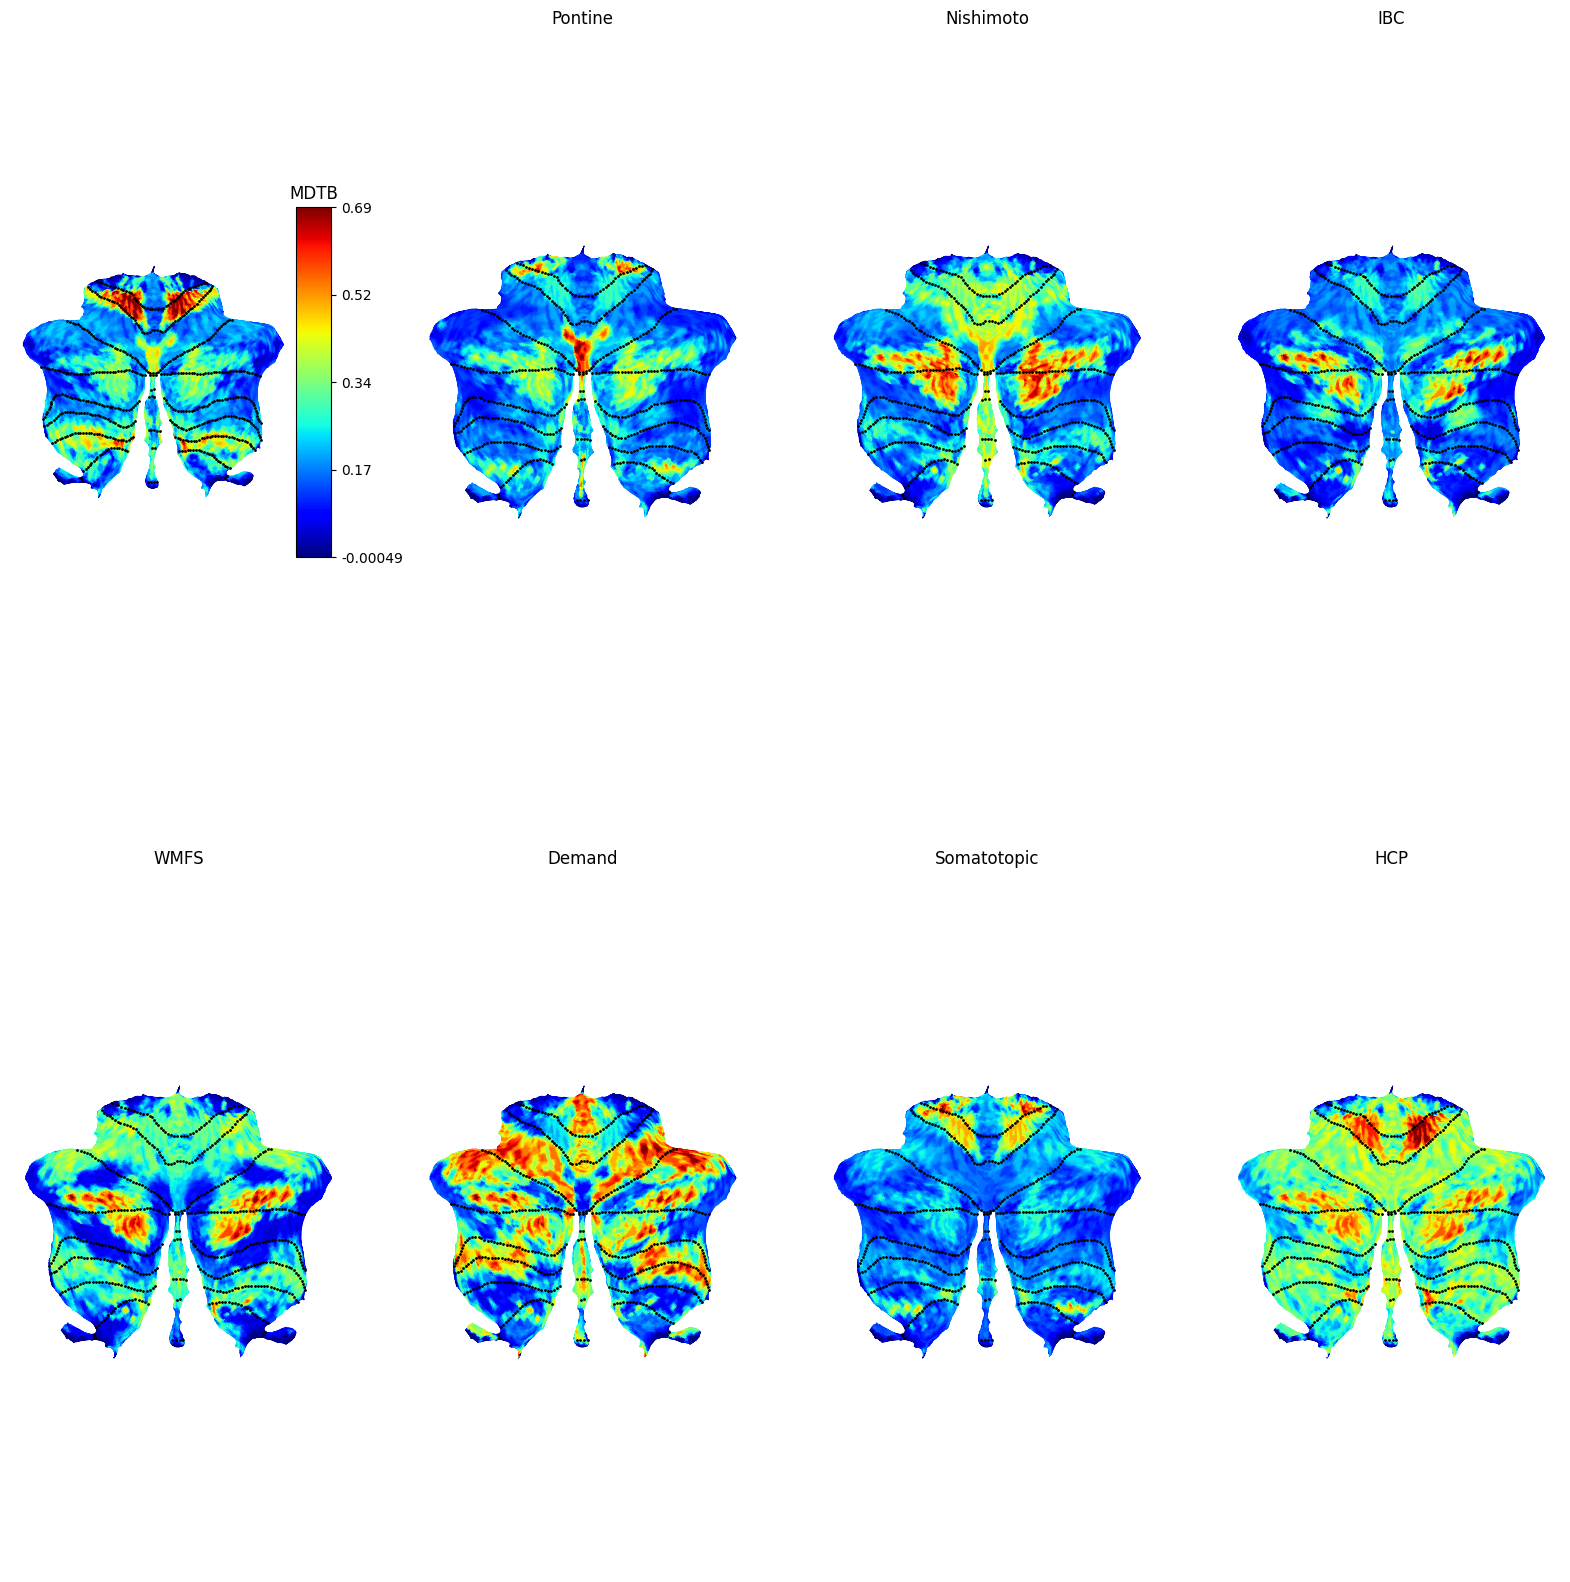

In [18]:
plt.figure(figsize=(20, 20))
T = pd.read_csv(ut.base_dir + '/dataset_description.tsv', sep='\t')
ut.plot_multi_flat(weights_flatmap, 'MNISymC3',
                   grid=(2, 4),
                   dtype='func',
                   colorbar=True,
                   titles=T.name)


### Weighted profile

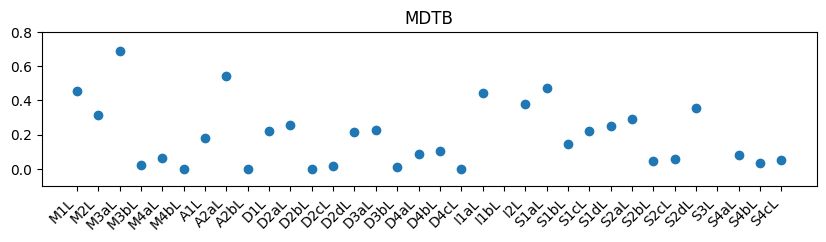

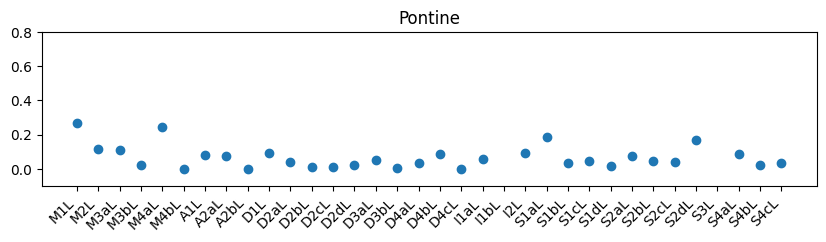

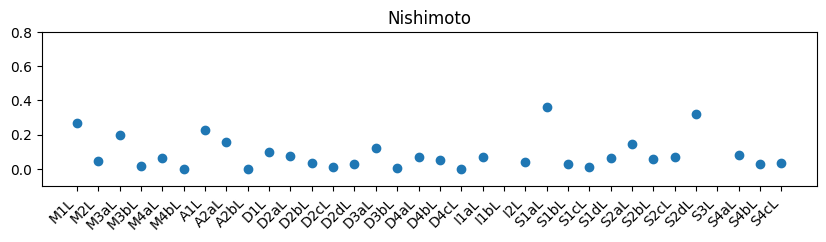

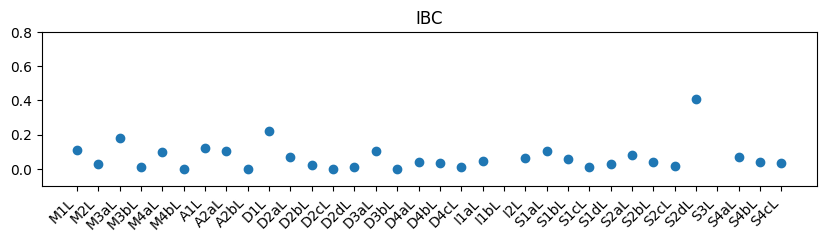

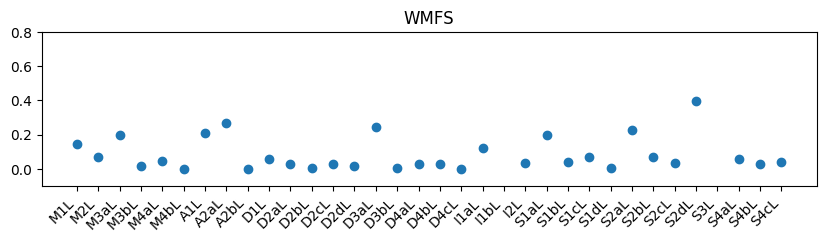

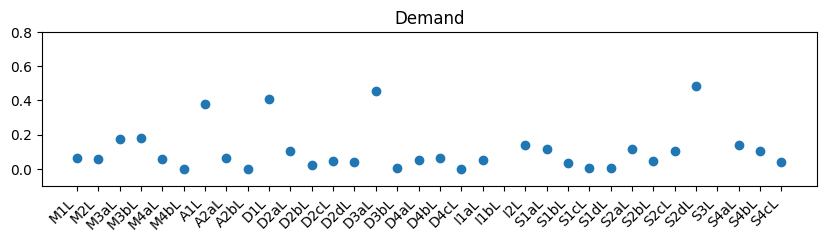

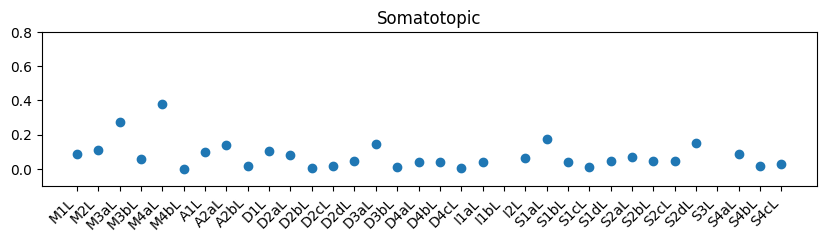

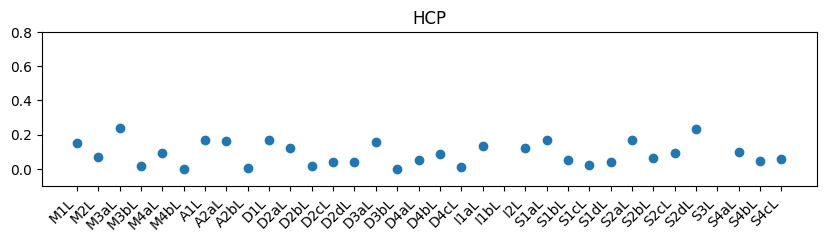

In [19]:
# Plot mean weights for each parcel (only left half of brain)
for w, weight in enumerate(mean_weights):
    plt.figure(figsize=(10, 2))
    weight_half = weight[:,:weight.shape[1] // 2]
    plt.scatter(np.arange(weight_half.shape[1]), weight_half)
    plt.ylim(-0.1, 0.8)
    plt.xticks(ticks=np.arange(weight_half.shape[1]),
               labels=labels[:weight_half.shape[1]], rotation=45, ha='right')
    plt.title(T.iloc[w]['name'])
    plt.show()
    


([<matplotlib.axis.YTick at 0x7fac4a418c10>,
 [Text(0, 0, 'NoGo'),
  Text(0, 5, 'UnpleasantScenes'),
  Text(0, 10, 'SadFaces'),
  Text(0, 15, 'FingerSeq'),
  Text(0, 20, 'SpatialNavigation'),
  Text(0, 25, 'VisualSearchSmall'),
  Text(0, 30, 'Prediction'),
  Text(0, 35, 'SpatialNavigation'),
  Text(0, 40, 'RomanceMovie'),
  Text(0, 45, 'MentalRotMed'),
  Text(0, 50, 'BodyMotionScram'),
  Text(0, 55, 'VisualSearchMed'),
  Text(0, 60, 'rest'),
  Text(0, 65, 'theory-of-mind'),
  Text(0, 70, 'AnimalPhoto'),
  Text(0, 75, 'Clock'),
  Text(0, 80, 'DailyPhoto'),
  Text(0, 85, 'DecideShopping'),
  Text(0, 90, 'DomesiticName'),
  Text(0, 95, 'EyeMoveEasy'),
  Text(0, 100, 'ForeignListenQ'),
  Text(0, 105, 'ImagineIf'),
  Text(0, 110, 'MapIcon'),
  Text(0, 115, 'MemoryDigit'),
  Text(0, 120, 'MirrorImage'),
  Text(0, 125, 'PressLR'),
  Text(0, 130, 'PropLogic'),
  Text(0, 135, 'RateDeliciousMov'),
  Text(0, 140, 'RateHappyMov'),
  Text(0, 145, 'RatePoem'),
  Text(0, 150, 'RateSleepy'),
  Text(0,

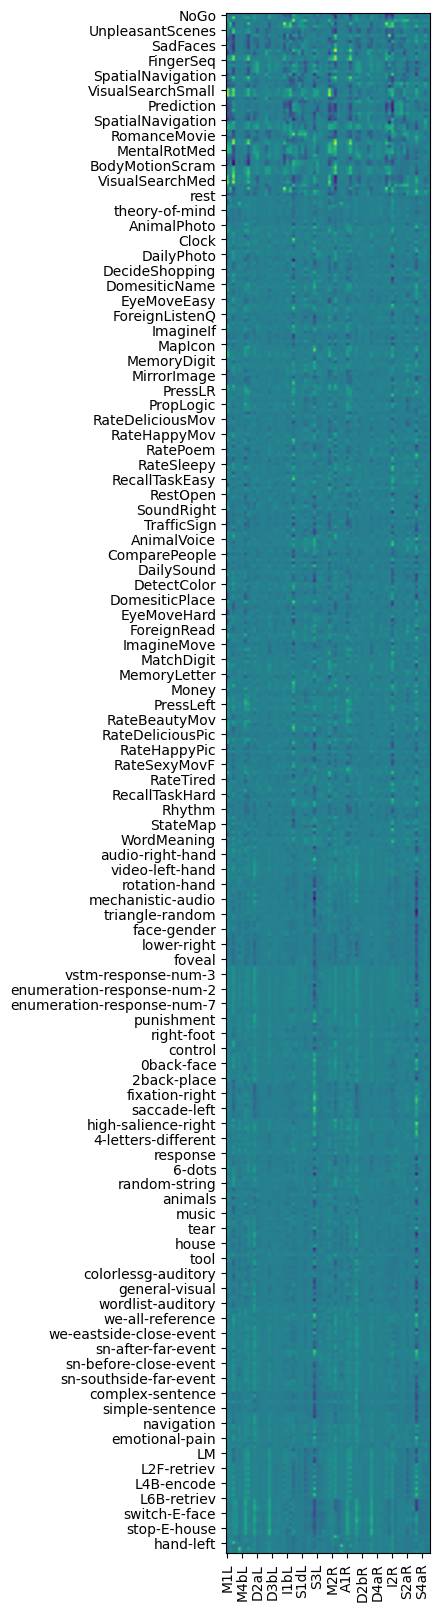

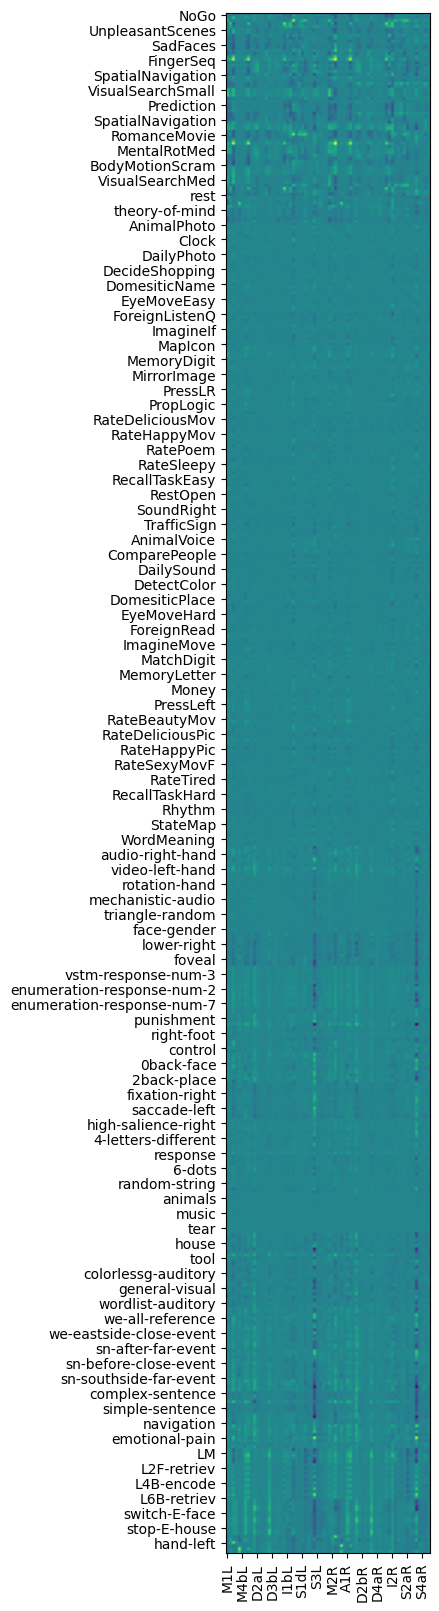

In [20]:

profile_norm_weighted = profile_norm.copy()
profile_weighted = profile_mat.copy()
for d, dataset in enumerate(T.name[:-1]):
    weight = mean_weights[d]
    weight[np.where(np.isnan(weight))] = np.nanmean(weight)
    profile_weighted[profile.dataset ==
                     dataset] = profile_weighted[profile.dataset == dataset] * weight
    profile_norm_weighted[profile.dataset ==
                            dataset] = profile_norm_weighted[profile.dataset == dataset] * weight

# Show normalized & weighted profile
plt.figure(figsize=(40, 20))
plt.imshow(profile_norm_weighted)
plt.xticks(np.arange(len(labels))[::5], labels[::5], rotation=90)
plt.yticks(np.arange(len(profile))[::5], profile.condition[::5])

# Show weighted profile
plt.figure(figsize=(40, 20))
plt.imshow(profile_weighted)
plt.xticks(np.arange(len(labels))[::5], labels[::5], rotation=90)
plt.yticks(np.arange(len(profile))[::5], profile.condition[::5])


In [21]:
# Print weighted profile
for region in ['M1R', 'M2R', 'M3aR', 'M3bR', 'M3bL', 'M4aR']:
    print_highest(profile_weighted, profile, labels, region=region)
    print_highest(profile_norm_weighted, profile, labels, region=region)
    # print_highest(profile_mat, profile, labels, region=region)
    # print_tags(features, tags, labels, region=region)
    # print_tags(features_norm, tags, labels, region=region, n=10)


region M1R
MDTB VisualSearchLarge: 0.2075875629323357
MDTB ToM: 0.1779858741155884
MDTB VisualSearchMed: 0.17323841414120128
MDTB VisualSearchSmall: 0.15644102759805922
MDTB SpatialMedDiff: 0.1478429603088778

region M1R
MDTB VisualSearchLarge: 0.15500421016025023
MDTB VisualSearchMed: 0.13853005053472164
MDTB VisualSearchSmall: 0.12771560094065143
MDTB VisualSearchLarge: 0.12568865715687333
MDTB VisualSearchSmall: 0.08529336656941308

region M2R
MDTB FingerSeq: 0.20662591840147226
MDTB FingerSeq: 0.1378751514068677
MDTB VideoAct: 0.10258694122754297
MDTB SpatialMedDiff: 0.101740797019268
Pontine finger-sequence: 0.09817500512764711

region M2R
MDTB FingerSeq: 0.07386168925448558
MDTB MentalRotDiff: 0.06027699604308897
MDTB StroopIncon: 0.05905025701029328
MDTB MentalRotMed: 0.05835514876395288
MDTB VideoAct: 0.057963454471468515

region M3aR
MDTB FingerSeq: 0.4210197977751916
MDTB FingerSeq: 0.4035215682780899
Somatotopic hand-right: 0.2584758361957267
MDTB FingerSimple: 0.2205113053

In [26]:
# Print weighted profile
for region in ['M2R']:
    print(f'\nProfile raw')
    print_highest(profile_mat, profile, labels, region=region)

    print(f'\nProfile normalized')
    print_highest(profile_norm, profile, labels, region=region)

    print(f'\nProfile weighted')
    print_highest(profile_weighted, profile, labels, region=region)
    
    print(f'\nProfile weighted + normalized')
    print_highest(profile_norm_weighted, profile, labels, region=region)

    print(f'\nFeatures raw')
    print_tags(features, tags, labels, region=region)

    print(f'\nFeatures normalized')
    print_tags(features_norm, tags, labels, region=region, n=10)



Profile raw

region M2R
IBC target-fruit: 0.8564596
Pontine finger-sequence: 0.8215279
Somatotopic tongue: 0.81145626
IBC pain: 0.6944477
IBC probe: 0.67110324

Profile normalized

region M2R
IBC right-foot: 0.31415901825060566
Nishimoto MatchNameHard: 0.2946517547297186
IBC mental: 0.29017237227028386
Nishimoto RecallPast: 0.2770002626524766
Nishimoto RateSexyPicF: 0.25897459321170013

Profile weighted

region M2R
MDTB FingerSeq: 0.20662591840147226
MDTB FingerSeq: 0.1378751514068677
MDTB VideoAct: 0.10258694122754297
MDTB SpatialMedDiff: 0.101740797019268
Pontine finger-sequence: 0.09817500512764711

Profile weighted + normalized

region M2R
MDTB FingerSeq: 0.07386168925448558
MDTB MentalRotDiff: 0.06027699604308897
MDTB StroopIncon: 0.05905025701029328
MDTB MentalRotMed: 0.05835514876395288
MDTB VideoAct: 0.057963454471468515

Features raw

region M2R
right_hand_response_execution: 31.905007479900007
left_hand_response_execution: 25.576832536399998
response_execution: 11.4618934083